In [1]:
import numpy as np
%matplotlib notebook
import matplotlib.pyplot as plt
from matplotlib.widgets import Slider
from matplotlib.animation import FuncAnimation
from ipywidgets import interact
from scipy.integrate import solve_ivp
from importlib import reload
import ptracer as pt

In [2]:
def quaternion(angle, vector):
    vector = np.array(vector).astype(float)
    vector /= np.sqrt(vector[0]**2 + vector[1]**2 + vector[2]**2)
    return np.array((np.cos(angle/2), *np.sin(angle/2)*np.array(vector)))

def quat_prod(p, q):
    res = np.zeros(4)
    p, q = np.array((p,q))
    res[0] = p[0]*q[0] - np.dot(p[1:], q[1:])
    res[1:] = p[0]*q[1:] + q[0]*p[1:] + np.cross(p[1:], q[1:])
    return res

In [23]:
quaternion(np.pi/2,[1,1,0])

array([0.70710678, 0.5       , 0.5       , 0.        ])

In [24]:
quaternion(0,[1,0,0])

array([1., 0., 0., 0.])

In [25]:
quat_prod(quaternion(0,[1,0,0]), [0,1,0,0])

array([0., 1., 0., 0.])

Format: `[q_1, q_2, q_3, q_4, w1, w2, w3]`

In [26]:
init = np.array((*quaternion(0,[1,0,0]), np.pi,0,0))
print(init)

[1.         0.         0.         0.         3.14159265 0.
 0.        ]


In [3]:
def derivatives(t, state, forces, I):
    res = np.zeros(7)
    q, w = state[:4], state[4:]
    if len(forces):
        moments = np.sum([force(state, t) for force in forces], axis=0)
        moments = quat_prod(quat_prod(q*[1,-1,-1,-1], (0, *moments)), q)[1:]
    else:
        moments = [0,0,0]
    res[:4] = quat_prod(.5*q, (0, *w))
    res[4:] = (moments - np.cross(w, I*w)) / I
    return res

In [30]:
derivatives(0, init, [], np.array((1,1,1)))

array([0.        , 1.57079633, 0.        , 0.        , 0.        ,
       0.        , 0.        ])

In [31]:
def euler(func, init, t, args):
    r = np.zeros((len(t), len(init)))
    r[0] = init
    for i in range(1, len(t)):
        r[i] = r[i-1] + (t[i]-t[i-1]) * func(t[i-1], r[i-1], *args)
    return r

# Display functions

In [4]:
def slide(qs):
    fig = plt.figure(figsize=(6,6))
    ax = fig.add_subplot(111, projection='3d')
    ax.set_xlim(-1,1)
    ax.set_ylim(-1,1)
    ax.set_zlim(-1,1)

    xr = quat_prod(quat_prod(qs[0], [0,1,0,0]), qs[0]*[1,-1,-1,-1])
    lx, = ax.plot([0,xr[1]], [0, xr[2]], [0, xr[3]], c="tab:red")

    yr = quat_prod(quat_prod(qs[0], [0,0,1,0]), qs[0]*[1,-1,-1,-1])
    ly, = ax.plot([0,yr[1]], [0, yr[2]], [0, yr[3]], c="tab:green")

    zr = quat_prod(quat_prod(qs[0], [0,0,0,1]), qs[0]*[1,-1,-1,-1])
    lz, = ax.plot([0,zr[1]], [0, zr[2]], [0, zr[3]], c="tab:blue")

    @interact(val=(0,len(qs)-1))
    def update(val=0):
        i = val
        # update curve
        xr = quat_prod(quat_prod(qs[i], [0,1,0,0]), qs[i]*[1,-1,-1,-1])
        lx.set_data([0,xr[1]], [0, xr[2]])
        lx.set_3d_properties([0, xr[3]])

        yr = quat_prod(quat_prod(qs[i], [0,0,1,0]), qs[i]*[1,-1,-1,-1])
        ly.set_data([0,yr[1]], [0, yr[2]])
        ly.set_3d_properties([0, yr[3]])

        zr = quat_prod(quat_prod(qs[i], [0,0,0,1]), qs[i]*[1,-1,-1,-1])
        lz.set_data([0,zr[1]], [0, zr[2]])
        lz.set_3d_properties([0, zr[3]])
        # redraw canvas while idle
        fig.canvas.draw_idle()


    plt.tight_layout()
    plt.show()

In [5]:
# Doesn't currently work!
def animate(qs, fig, save=None):
    ax = fig.add_subplot(111, projection='3d')

    xr = quat_prod(quat_prod(qs[0], [0,1,0,0]), qs[0]*[1,-1,-1,-1])
    lx, = ax.plot([0,xr[1]], [0, xr[2]], [0, xr[3]], c="tab:red")

    yr = quat_prod(quat_prod(qs[0], [0,0,1,0]), qs[0]*[1,-1,-1,-1])
    ly, = ax.plot([0,yr[1]], [0, yr[2]], [0, yr[3]], c="tab:green")

    zr = quat_prod(quat_prod(qs[0], [0,0,0,1]), qs[0]*[1,-1,-1,-1])
    lz, = ax.plot([0,zr[1]], [0, zr[2]], [0, zr[3]], c="tab:blue")


    plt.tight_layout()
    plt.show()

    def init():
    #     ax.set_xlim(0, 2*np.pi)
    #     ax.set_ylim(-1, 1)
        return lx, ly, lz

    def update(frame):
        i = frame
        # update curve
        xr = quat_prod(quat_prod(qs[i], [0,1,0,0]), qs[i]*[1,-1,-1,-1])
        lx.set_data([0,xr[1]], [0, xr[2]])
        lx.set_3d_properties([0, xr[3]])

        yr = quat_prod(quat_prod(qs[i], [0,0,1,0]), qs[i]*[1,-1,-1,-1])
        ly.set_data([0,yr[1]], [0, yr[2]])
        ly.set_3d_properties([0, yr[3]])

        zr = quat_prod(quat_prod(qs[i], [0,0,0,1]), qs[i]*[1,-1,-1,-1])
        lz.set_data([0,zr[1]], [0, zr[2]])
        lz.set_3d_properties([0, zr[3]])
        # redraw canvas while idle
        fig.canvas.draw_idle()
        return lx, ly, lz

    ani = FuncAnimation(fig, update, frames=np.arange(len(qs)),
                        init_func=init, blit=True, interval=10)
    if save is not None:
        ani.save("Dzhanibekov.mp4")
    plt.show()
#     return fig

# Basic instability and the Dzhanibekov effect

In [34]:
init = np.array((*quaternion(np.pi/2,[1,0,0]), 0,np.pi,0))
res = euler(derivatives, init, np.linspace(0,1,100), args=([], np.array((1,1,1))))
qs = res[:,:4]

In [35]:
init = np.array((*quaternion(0,[1,0,0]), 1e-3,np.pi,1e-3))
res = solve_ivp(derivatives, (0,25), init, args=([], np.array((1,2,3))), t_eval=np.linspace(0,25,1000))
qs = res.y.T[:,:4]

<IPython.core.display.Javascript object>


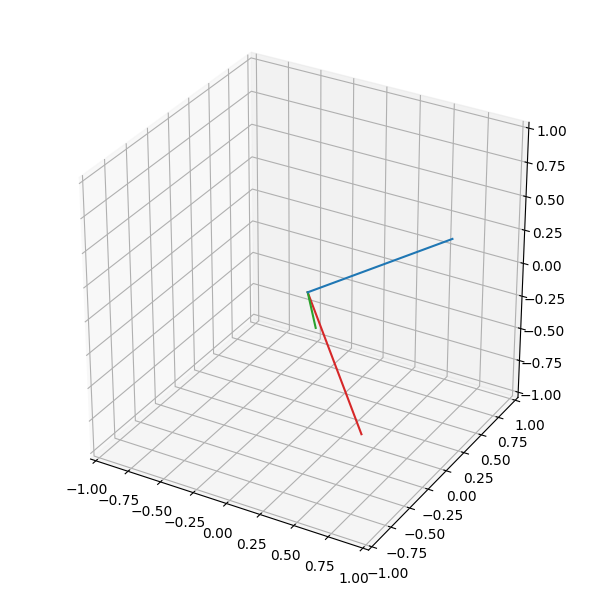

interactive(children=(IntSlider(value=0, description='val', max=999), Output()), _dom_classes=('widget-interac…

In [36]:
slide(qs)

# Forces

In [142]:
def constant_factory(value):
    f = np.array(value)
    def constant(state, t):
        return f
    return constant

def restoring_factory(coeff):
    def restoring(state, t):
        r = quat_prod(quat_prod(state[:4], [0,0,0,-1]), state[:4]*[1,-1,-1,-1])
        return np.cross(r[1:], [0,0,-coeff])
    return restoring

In [143]:
# Constant acceleration
forces = [constant_factory([0,1,0])]
init = np.array((*quaternion(np.pi/4,[0,0,1]), 0,0,0))
res = solve_ivp(derivatives, (0,10), init, args=(forces, np.array((1,1,1))), t_eval=np.linspace(0,10,1000))
qs = res.y.T[:,:4]

In [187]:
# Pendulum
forces = [restoring_factory(9.81)]
init = np.array((*quaternion(.1,[1,0,0]), 0,0,0))
res = solve_ivp(derivatives, (0,10), init, args=(forces, np.array((1,1,1))), t_eval=np.linspace(0,10,1000))
qs = res.y.T[:,:4]

<IPython.core.display.Javascript object>


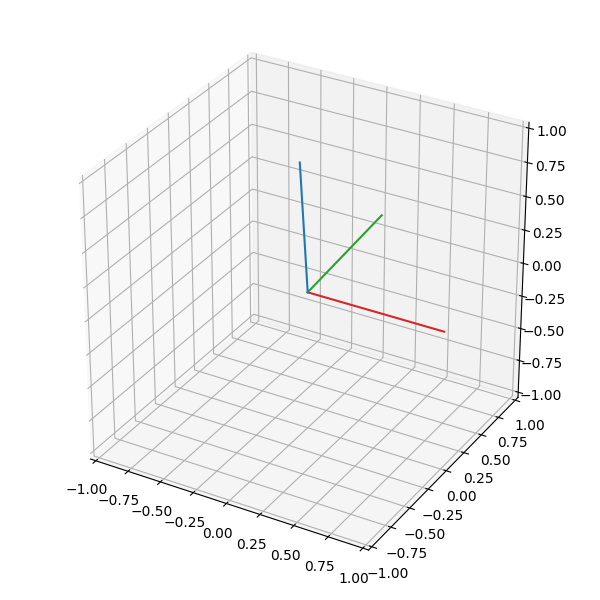

interactive(children=(IntSlider(value=0, description='val', max=999), Output()), _dom_classes=('widget-interac…

In [188]:
slide(qs)

<IPython.core.display.Javascript object>


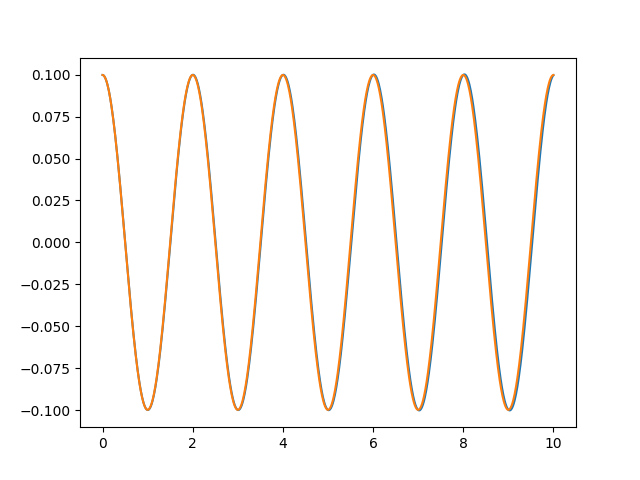

In [190]:
fig, ax = plt.subplots()
tspace = np.linspace(0,10,1000)
ax.plot(tspace,
        np.array([quat_prod(quat_prod(_q, [0,0,0,-1]), _q*[1,-1,-1,-1]) for _q in qs])[:,2])
ax.plot(tspace, np.sin(.1)*np.cos(np.pi*tspace))
plt.show()

# Old forces

In [191]:
import forces.buoyancy as fb

In [197]:
fb.factory({}, {"g":[0,0,-9.81], "density":1, "volume":1})([0,0,0,0],0)

array([-0.  , -0.  ,  9.81,  0.  ,  0.  ,  0.  ])

# Rotating many vectors at the same time

In [6]:
# quat_prod(quat_prod(qs[0], [0,0,1,0]), qs[0]*[1,-1,-1,-1])
def rotate(points, q):
    points = np.array(points)
    res = np.zeros((len(points), 4))
    # q*p
    res[:,0] = -np.sum(q[1:]*points, axis=1)
    res[:,1:] = q[0]*points + np.cross(q[1:], points)
    # (q*p) * q^-1
    res2 = np.zeros((len(points), 4))
    res2[:,0] = res[:,0]*q[0] - np.dot(res[:,1:], -q[1:])
    res2[:,1:] = res[:,0].reshape((-1,1))*(-q[1:]) + (q[0]*res[:,1:]) + np.cross(res[:,1:], -q[1:])
    return res2

In [358]:
rotate([[0,0,0],[1,0,0],[0,1,0],[0,0,1]], quaternion(np.pi/2, (1,0,0)))

array([[-0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00],
       [ 0.00000000e+00,  1.00000000e+00,  0.00000000e+00,
         0.00000000e+00],
       [-0.00000000e+00,  0.00000000e+00,  2.22044605e-16,
         1.00000000e+00],
       [-0.00000000e+00,  0.00000000e+00, -1.00000000e+00,
         2.22044605e-16]])

In [356]:
rotate([[1,0,0]], quaternion(np.pi/2, (1,1,0)))

[[-0.5         0.70710678  0.         -0.5       ]]
[[-0.5         0.70710678  0.         -0.5       ]] [0.70710678 0.5        0.5        0.        ]
[[0.25 0.25 0.  ]]
[[ 0.5         0.         -0.35355339]]
[[-0.25        0.25       -0.35355339]]


array([[ 0.        ,  0.5       ,  0.5       , -0.70710678]])

In [348]:
quat_prod(quaternion(np.pi/2, (1,1,0)), (0, *[1,0,0]))

[0.70710678 0.5        0.5        0.        ] [0. 1. 0. 0.]
[0.70710678 0.         0.        ]


array([-0.5       ,  0.70710678,  0.        , -0.5       ])

In [352]:
def quat_prod(p, q):
    res = np.zeros(4)
    p, q = np.array((p,q))
    res[0] = p[0]*q[0] - np.dot(p[1:], q[1:])
    print(p, q)
    print(p[0]*q[1:])
    print(q[0]*p[1:])
    res[1:] = p[0]*q[1:] + q[0]*p[1:] + np.cross(p[1:], q[1:])
    return res

In [353]:
quat_prod(quat_prod(quaternion(np.pi/2, (1,1,0)), (0, *[1,0,0])), quaternion(np.pi/2, (1,1,0))*(1,-1,-1,-1))

[0.70710678 0.5        0.5        0.        ] [0. 1. 0. 0.]
[0.70710678 0.         0.        ]
[0. 0. 0.]
[-0.5         0.70710678  0.         -0.5       ] [ 0.70710678 -0.5        -0.5        -0.        ]
[0.25 0.25 0.  ]
[ 0.5         0.         -0.35355339]


array([ 0.        ,  0.5       ,  0.5       , -0.70710678])

# Read in files

<IPython.core.display.Javascript object>


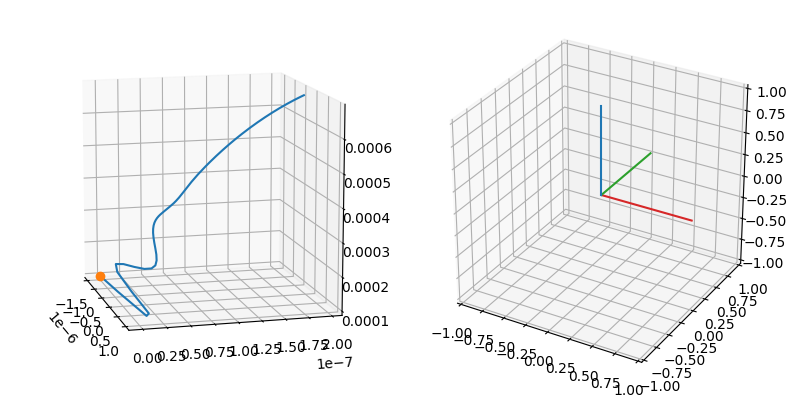

interactive(children=(IntSlider(value=0, description='val', max=499), Output()), _dom_classes=('widget-interac…

In [13]:
name = "output/2020-08-27-12-12-29-ico-sphere-3/"+"0.csv"
data = np.loadtxt(name, delimiter=",")
qs = data[:,7:11]
ps = data[:,1:4]

fig = plt.figure(figsize=(8,4))
ax1 = fig.add_subplot(121, projection='3d')
ax2 = fig.add_subplot(122, projection='3d')
ax2.set_xlim(-1,1)
ax2.set_ylim(-1,1)
ax2.set_zlim(-1,1)
plt.tight_layout()

xyz = np.array([[1,0,0], [0,1,0], [0,0,1]])
xr, yr, zr = rotate(xyz, qs[0])
lx, = ax2.plot([0,xr[1]], [0, xr[2]], [0, xr[3]], c="tab:red")
ly, = ax2.plot([0,yr[1]], [0, yr[2]], [0, yr[3]], c="tab:green")
lz, = ax2.plot([0,zr[1]], [0, zr[2]], [0, zr[3]], c="tab:blue")

lp, = ax1.plot(*ps.T)
lpi, = ax1.plot([ps[0,0]], [ps[0,1]], [ps[0,2]], "o")

@interact(val=(0,len(qs)-1))
def update(val=0):
    i = val
    # update curve
    xr, yr, zr = rotate(xyz, qs[i])
    lx.set_data([0,xr[1]], [0, xr[2]])
    lx.set_3d_properties([0, xr[3]])
    ly.set_data([0,yr[1]], [0, yr[2]])
    ly.set_3d_properties([0, yr[3]])
    lz.set_data([0,zr[1]], [0, zr[2]])
    lz.set_3d_properties([0, zr[3]])
    
    # update pointer
    lpi.set_data([ps[i,0]], [ps[i,1]])
    lpi.set_3d_properties([ps[i,2]])
    
    # redraw canvas while idle
    fig.canvas.draw_idle()

# Rotating TracerObjects
- [x] TracerObject
- [x] Surface
- [x] Sphere
- [x] Triangle
- [x] MeshTO
- [x] SmoothMeshTO

In [498]:
reload(pt)
# reload(pt.jm)

<module 'ptracer' from '/home/jdranczewski/Documents/Imperial/UROP20/optical-levitation-raytracing-experiments/ptracer.py'>

In [450]:
to = pt.TracerObject([1,0,0], ang_origin=[0.5,0,0], rot=quaternion(np.pi/2, (0,0,1)))
to.origin

array([0.5, 0.5, 0. ])

<IPython.core.display.Javascript object>


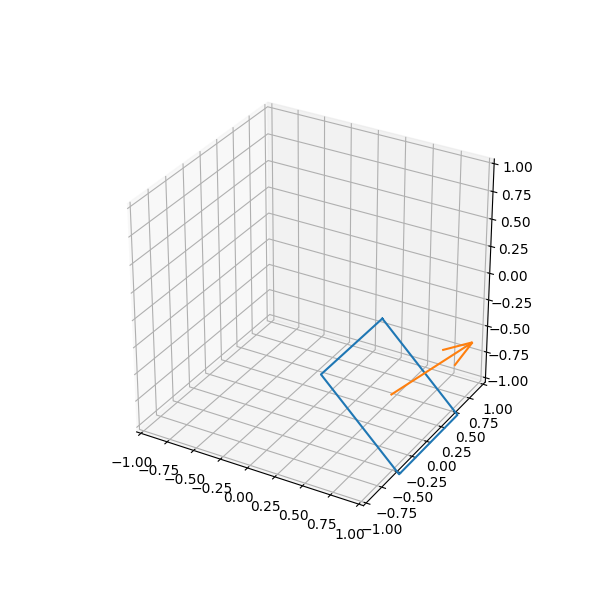

(-1.0, 1.0)

In [455]:
to = pt.Surface([1,0,0],[0,0,1], ang_origin=[0,0,0], rot=quaternion(np.pi/4, (0,1,0)))
fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot(111, projection='3d')
to.plot(ax)
ax.set_xlim(-1,1)
ax.set_ylim(-1,1)
ax.set_zlim(-1,1)

<IPython.core.display.Javascript object>


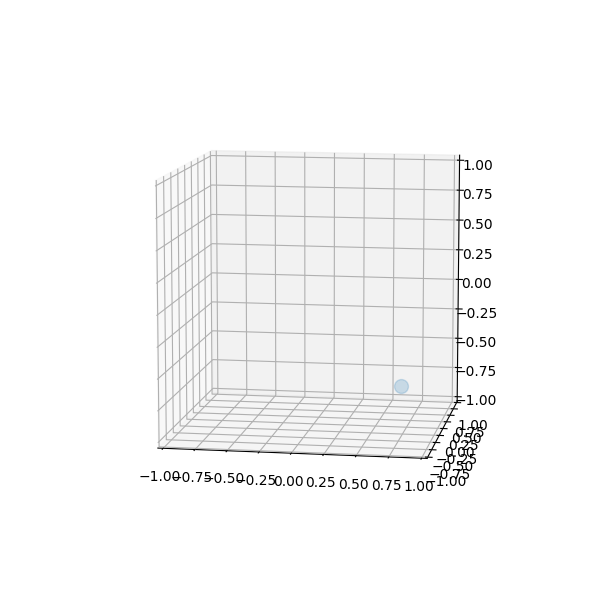

(-1.0, 1.0)

In [454]:
to = pt.Sphere([1,0,0],1, ang_origin=[0,0,0], rot=quaternion(np.pi/4, (0,1,0)))
fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot(111, projection='3d')
to.plot(ax)
ax.set_xlim(-1,1)
ax.set_ylim(-1,1)
ax.set_zlim(-1,1)

<IPython.core.display.Javascript object>


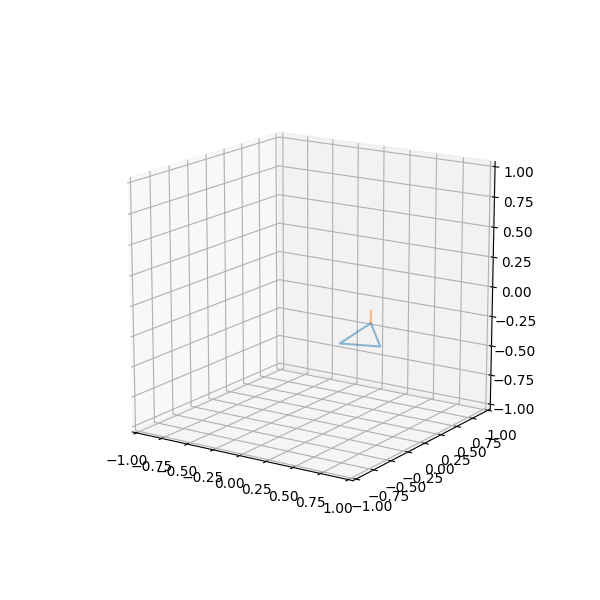

(-1.0, 1.0)

In [473]:
to = pt.Triangle([0.5,0,0],[.1,.1,.1],[.2,.7,.1], [.5,.6,.1], ang_origin=[0,0,0], rot=quaternion(np.pi, (1,0,0)))
fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot(111, projection='3d')
to.plot(ax)
ax.set_xlim(-1,1)
ax.set_ylim(-1,1)
ax.set_zlim(-1,1)

<IPython.core.display.Javascript object>


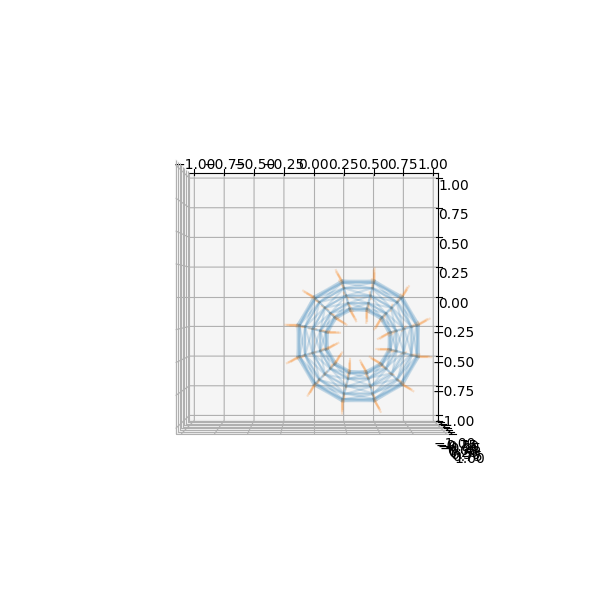

(-1.0, 1.0)

In [495]:
to = pt.MeshTO([.5,0,0], "torus.obj", .5, ang_origin=[0,0,0], rot=quaternion(-np.pi/4, (0,0,1)))
fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot(111, projection='3d')
to.plot(ax)
ax.set_xlim(-1,1)
ax.set_ylim(-1,1)
ax.set_zlim(-1,1)

<IPython.core.display.Javascript object>


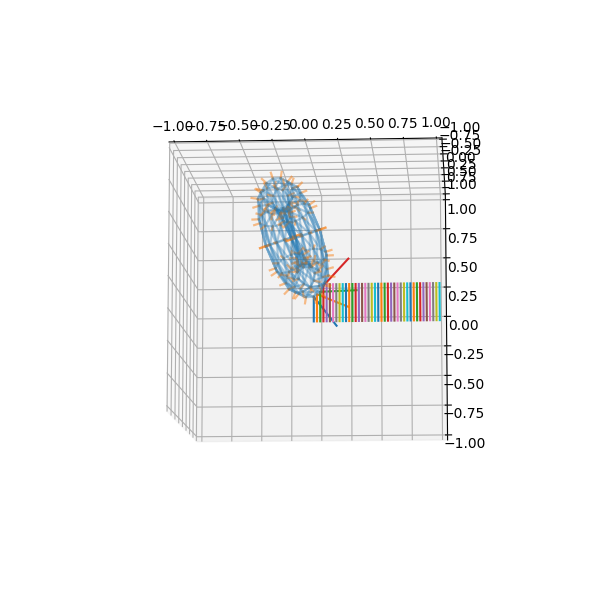

(-1.0, 1.0)

In [552]:
to = pt.SmoothMeshTO([.5,0,0], "torus.obj", .5, ang_origin=[0,0,0], rot=quaternion(-np.pi/4, (0,1,0)), n_in=1.3, reflective=True)
rf = pt.BasicRF(np.linspace(0,1,40), 0, -0.2, [0,0,1])
s = pt.Scene(rf, [to])
s.run(limit=2)
s.propagate(.3)
fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot(111, projection='3d')
s.plot(ax)
ax.set_xlim(-1,1)
ax.set_ylim(-1,1)
ax.set_zlim(-1,1)